# day 1: points
>30DayMapChallenge classic: A map with points. Start the challenge with points. Show individual locations—anything from cities to trees or more abstract concepts. Simple, but a key part of the challenge. 📍

- note to self. use `osm` environment

In [7]:
import cartopy.crs as ccrs
import geopandas as gpd
from matplotlib.font_manager import fontManager
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import osmnx as ox
import shapely

In [8]:
# add official SBB rail fonts
fontManager.addfont('../../../../../fonts/Grafikdateien-SBB-Font/WEB/SBBWeb-Roman.ttf')
fontManager.addfont('../../../../../fonts/Grafikdateien-SBB-Font/WEB/SBBWeb-Italic.ttf')
ox.settings.max_query_area_size = 5e10

In [9]:
# polygon of zurich hbf and a bit.
zurich_hbf_wkt = '''
POLYGON ((8.5129885 47.3756546, 8.5428000 47.3756546, 8.5428000 47.38920, 8.5129885 47.38920, 8.5129885 47.3756546))
'''
zurich = shapely.from_wkt(zurich_hbf_wkt)

# get features from OpenStreetMap
zurich_features = ox.features_from_polygon(zurich,
                                           tags={'railway': ['switch', 'rail']})

# get utm crs, and cartopy projection for passing to matplotlib
utm_crs = zurich_features.estimate_utm_crs()
prj = ccrs.epsg(utm_crs.to_epsg())

# for setting axes limits in the projected coordinate system
minx, miny, maxx, maxy = gpd.GeoSeries([zurich], crs=4326).to_crs(utm_crs).total_bounds

# filter the features for just the points (switches)
z_switches = zurich_features[zurich_features['railway'] == 'switch'].to_crs(utm_crs)

# filter features for just railways - `usage` gets rid of the 'yard' and helps make it look less cluttered
z_rails = zurich_features[(zurich_features['railway'] == 'rail') & 
                          (zurich_features['boat'].isna()) &
                          (~zurich_features['usage'].isna())].to_crs(utm_crs)

# only include swithces that are on the rails filtered
mls = shapely.MultiLineString(z_rails['geometry'].tolist())
z_switches = z_switches[z_switches.intersects(mls)]

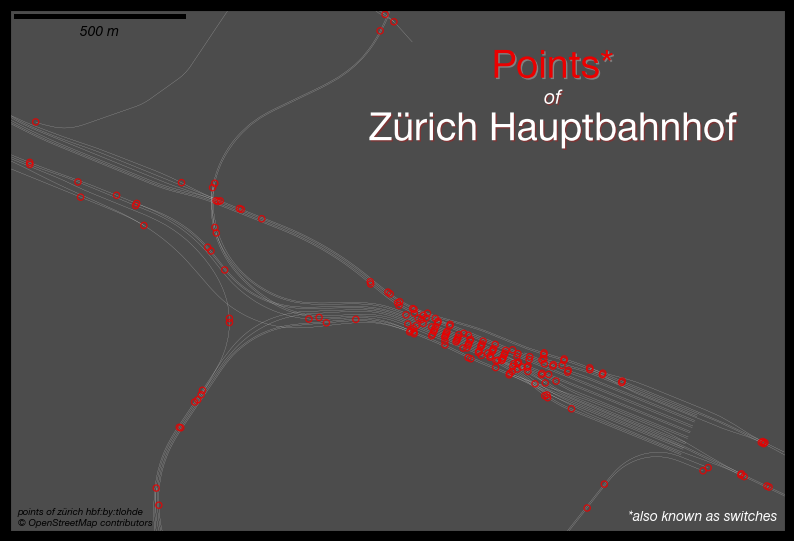

In [38]:
## official red and gray for swiss railway operator SBB
sbbred = (235/255,  0, 0)
sbbgray = (76/255,) * 3

fig, ax = plt.subplots(subplot_kw={'projection':prj},
                       figsize=[10, 10])

z_rails.plot(color='w',
             linewidth=0.1,
             zorder=0,
             ax=ax)

z_switches.plot(marker='o',
                color=sbbred,
                facecolor='none',
                markersize=20,
                linewidth=1,
                alpha=0.8,
                # path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1))]
                zorder=2,
                ax=ax)

# scale bar
scalebar = ScaleBar(1,
                    "m",
                    location='upper left',
                    length_fraction=0.25,
                    box_alpha=0,
                    scale_loc='bottom',
                    font_properties={'family': 'SBB Web',
                                     'style':'italic'})
ax.add_artist(scalebar)

# title
ax.annotate('Points*',
            xy=(0.7,0.87),
            xycoords='axes fraction',
            ha='center',
            fontsize=28,
            font='SBB Web',
            color=sbbred,
            path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1),
                                                             shadow_rgbFace='w')]
            )

ax.annotate('of',
            xy=(0.7, 0.82),
            xycoords='axes fraction',
            ha='center',
            fontstyle='italic',
            fontsize=14,
            font='SBB Web',
            color='w',
            path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1),
                                                             shadow_rgbFace=sbbred)]
            )

ax.annotate('Zürich Hauptbahnhof',
            xy=(0.7, 0.75),
            xycoords='axes fraction',
            ha='center',
            fontsize=28,
            font='SBB Web',
            color='w',
            path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1),
                                                             shadow_rgbFace=sbbred)]
            )

# footnote
ax.annotate('*also known as switches',
            xy=(0.99, 0.02),
            xycoords='axes fraction',
            ha='right',
            fontsize=10,
            fontstyle='italic',
            font='SBB Web',
            color='w',
            )

# attribution
ax.annotate('points of zürich hbf:by:tlohde\n© OpenStreetMap contributors',
                     xy=(0.01,0.01),
                     xycoords='axes fraction',
                     font='SBB Web',
                     fontstyle='italic',
                     fontsize=7)

# set background and limits
ax.set_facecolor(sbbgray)
ax.set(xlim=(minx, maxx),
       ylim=(miny, maxy))

fig.patch.set_color('k')

# fig.savefig('day1_zurich.png', dpi=300, bbox_inches='tight')